In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import netCDF4 as nc
import statsmodels.api as sm
import numpy as np

In [3]:
# read data
gdp_data_path = '/carnegie/data/Shared/Labs/Caldeira Lab/Everyone/'

gdp = pd.read_csv(os.path.join(gdp_data_path, 'gdp_pop_energy_data/API_NY.GDP.PCAP.CD_DS2_en_csv_v2_5447781.csv'), header=2)
# Source for GDP: https://data.worldbank.org/


exp_temp_data_path = '/carnegie/data/Shared/Labs/Caldeira Lab/Everyone/exp_temperature_data/'

cdd_18 = pd.read_excel(os.path.join(exp_temp_data_path, 'Enhanced-Degree-Days-Database-March-2015.xlsx'), sheet_name='t2m.cdd.18C')
hdd_18 = pd.read_excel(os.path.join(exp_temp_data_path, 'Enhanced-Degree-Days-Database-March-2015.xlsx'), sheet_name='T2m.hdd.18C')
# Source for CDD and HDD: https://www.kapsarc.org/research/projects/global-degree-days-database/

frac_people_aggr = pd.read_csv(os.path.join(exp_temp_data_path, 'GDP-vs-agriculture-employment.csv'))
# Source https://ourworldindata.org/grapher/GDP-vs-agriculture-employment

# cdd_18_alt = nc.Dataset(os.path.join(exp_temp_data_path, 'CDD_netcdf/gldas_0p25_deg_cdd_base_T_18C_1970_2018_ann.nc4'))
# Source: https://doi.pangaea.de/10.1594/PANGAEA.903123

ipcc_scenarios = pd.read_csv(os.path.join(exp_temp_data_path, 'ipcc-scenarios.csv'))
# Source: https://ourworldindata.org/explorers/ipcc-scenarios?facet=none&country=SSP1+-+Baseline~SSP2+-+Baseline~SSP3+-+Baseline~SSP4+-+Baseline~SSP5+-+Baseline&Metric=Temperature+increase&Rate=Per+capita&Region=Global

In [4]:
# preprocess data

# Rearrange GDP data
gdp = gdp.set_index('Country Name')
gdp = gdp.drop(columns=['Country Code', 'Indicator Name', 'Indicator Code'])
gdp = gdp.stack()
gdp = gdp.reset_index()
gdp.columns = ['Country Name', 'Year', 'GDP']
# Year column is string, convert to int
gdp['Year'] = gdp['Year'].astype(int)
gdp = gdp.set_index(['Country Name', 'Year'])
gdp_world = gdp.loc['World']
# print("GDP world")
# print (gdp_world)

# Rearrange DD data
def rearrange_dd(dd_df, var='CDD'):
    dd_df = dd_df.set_index('Country')
    # Drop rows after Zimbabwe
    dd_df = dd_df.drop(dd_df.index[range(dd_df.index.get_loc('Mean')+1, len(dd_df))])
    #Drop columns that are not years
    dd_df = dd_df.drop(columns=['6 hrs AVERAGE  1964-2013', 'Daily AVERAGE 1964-2013'])
    dd_df = dd_df.stack()
    dd_df = dd_df.reset_index()
    dd_df.columns = ['Country Name', 'Year', var]
    # Convert from 6h to daily frequency
    dd_df[var] = dd_df[var]/4.
    dd_df = dd_df.set_index(['Country Name', 'Year'])
    return dd_df

cdd = rearrange_dd(cdd_18, var='CDD')
cdd_world = cdd.loc['Mean']
hdd = rearrange_dd(hdd_18, var='HDD')
hdd_world = hdd.loc['Mean']
# print("CDD world")
# print (cdd_world)

# Rearrange frac_people_aggr data
frac_people_aggr = frac_people_aggr.set_index(['Entity', 'Year'])
frac_people_aggr = frac_people_aggr['share_employed_agri']
frac_people_aggr_world = frac_people_aggr.loc['World']
# print(frac_people_aggr_world)

# combine data sources
df = pd.concat([gdp, cdd], axis=1)
# df = pd.concat([df, hdd], axis=1)
df = pd.concat([df, frac_people_aggr], axis=1)
df.dropna(inplace=True)
pd.set_option('display.max_rows', None)
print(df)

                                         GDP          CDD  share_employed_agri
                         Year                                                 
Angola                   1991     867.123435  1613.979975            39.830002
                         1992     657.653384  1686.040050            39.900002
                         1993     442.445234  1632.979975            40.209999
                         1994     329.691784  1612.785025            40.090000
                         1995     398.120223  1735.545050            39.560001
                         1996     523.274940  1677.395025            38.980000
                         1997     514.309887  1609.714975            38.540001
                         1998     423.393453  1863.704950            38.160000
                         1999     387.689415  1675.290050            37.860001
                         2000     556.884244  1712.137450            37.500000
                         2001     527.463202  1765.2

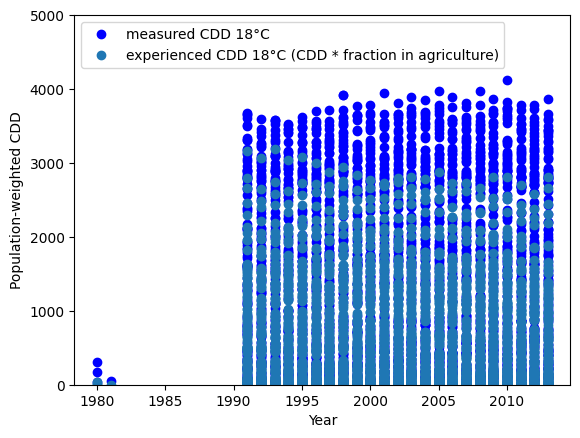

In [4]:
# plot
fig_cdd, ax_cdd = plt.subplots()
# Year vs GDP
ax_cdd.plot(df.index.get_level_values('Year'), df['CDD'], color='b', marker='o', linestyle='None', label='measured CDD 18°C')
# ax.plot(df.index.get_level_values('Year'), df['HDD'], color='r', marker='o', linestyle='None', label='measured HDD 18°C')
ax_cdd.plot(df.index.get_level_values('Year'), df['CDD']*df['share_employed_agri']/100., color='tab:blue', marker='o', linestyle='None', label='experienced CDD 18°C (CDD * fraction in agriculture)')
# ax.plot(df.index.get_level_values('Year'), df['HDD']*df['share_employed_agri']/100., color='tab:red', marker='o', linestyle='None', label='experienced HDD 18°C')
ax_cdd.set_xlabel('Year')
ax_cdd.set_ylabel('Population-weighted CDD')
# ax.set_xlim([1980, 2013])
ax_cdd.set_ylim([0, 5000.])


# Legend at upper right inside plot
ax_cdd.legend(loc='upper left', bbox_to_anchor=(0., 1.0))
plt.savefig('experienced_CDD.png', dpi=300, bbox_inches='tight')

/tmp/ipykernel_1159563/2602101240.py:20: RuntimeWarning: divide by zero encountered in power
  return a * x**(-0.75)


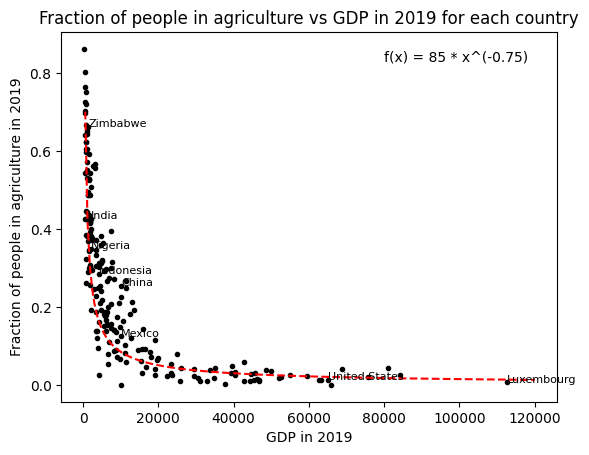

In [5]:
# GDP of all countries in 2021
gdp_2019 = gdp[gdp.index.get_level_values('Year') == 2019]
frac_people_aggr_2019 = frac_people_aggr[frac_people_aggr.index.get_level_values('Year') == 2019]

df_2019 = pd.concat([gdp_2019, frac_people_aggr_2019], axis=1)
df_2019.dropna(inplace=True)
# Add a point for GDP = 0
# df_2019.loc['Zero'] = [0, 100]
df_2019['share_employed_agri'] = df_2019['share_employed_agri']/100.

# Plot GDP vs fraction of people in agriculture
fig, ax = plt.subplots()
ax.plot(df_2019['GDP'], df_2019['share_employed_agri'], color='k', marker='o', markersize=3, linestyle='None')
ax.set_xlabel('GDP in 2019')
ax.set_ylabel('Fraction of people in agriculture in 2019')

# Fit function
from scipy.optimize import curve_fit
def func(x, a):
    return a * x**(-0.75)

# Fit function to data
popt, pcov = curve_fit(func, df_2019['GDP'], df_2019['share_employed_agri'])
plot_x = np.linspace(0, 1.2e5, 200)
ax.plot(plot_x, func(plot_x, *popt), color='r', linestyle='--')

# Print fit function on plot
ax.text(0.65, 0.95, 'f(x) = {:.0f} * x^(-0.75)'.format(popt[0]), transform=ax.transAxes, fontsize=10, verticalalignment='top')
ax.title.set_text('Fraction of people in agriculture vs GDP in 2019 for each country')
# Label some points with country names
for country in ['China', 'India', 'United States', 'Indonesia', 'Nigeria', 'Mexico', 'Luxembourg', 'Zimbabwe']:
    ax.text(df_2019.loc[country]['GDP'], df_2019.loc[country]['share_employed_agri'], country, fontsize=8)

plt.savefig('countries_GDP_vs_agriculture.png', dpi=300, bbox_inches='tight')

# model = sm.OLS(df_2019['share_employed_agri'], df_2019['GDP'])
# result = model.fit()
# print(result.summary())
# print(result.params)
# ax.plot(df_2019['GDP'], result.fittedvalues, color='r', linestyle='--')

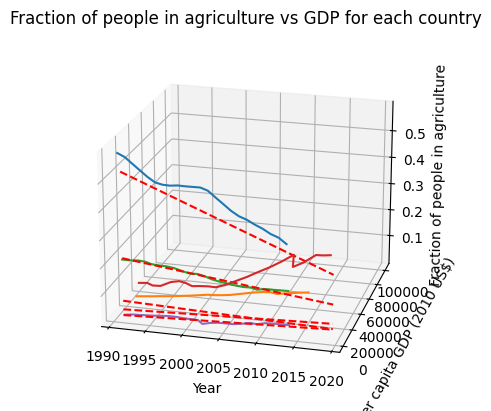

In [50]:

ax = plt.figure().add_subplot(projection='3d')

# Fit function
from scipy.optimize import curve_fit
def func(x, a, b, c):
    return a*x[0] + b*x[1] + c


for country in ['China', 'United States', 'Mexico', 'Norway', 'Argentina']:#df.index.get_level_values(0).unique():
    # ax.plot(df.loc[country]['GDP'], df.loc[country]['share_employed_agri']/100, marker='o', linestyle='--', markersize=1, linewidth=0.3, alpha=0.6)
    # Plot fraction of people in agriculture z as a function of GDP x and year y
    ax.plot(df.loc[country].index.get_level_values('Year'), df.loc[country]['GDP'], df.loc[country]['share_employed_agri']/100, zdir='z')
    # Fit function to data
    popt, pcov = curve_fit(func, [df.loc[country].index.get_level_values('Year'), df.loc[country]['GDP']], df.loc[country]['share_employed_agri']/100.)
    plot_x = [np.linspace(1991, 2019, 200), np.linspace(4e3, 1.1e4, 200)]
    ax.plot(plot_x[0], plot_x[1], func(plot_x, *popt), color='r', linestyle='--')

ax.set_xlabel('Year')
ax.set_ylabel('Per capita GDP (2010 US$)')
ax.set_zlabel('Fraction of people in agriculture')

ax.title.set_text('Fraction of people in agriculture vs GDP for each country')




# # Fit function to data
# popt, pcov = curve_fit(func, df['GDP'], df['share_employed_agri']/100.)
# plot_x = np.linspace(4e3, 1.1e4, 200)
# ax.plot(plot_x, func(plot_x, *popt), color='r', linestyle='--')
# ax.text(0.5, 0.95, 'f(x) = {:.2e} * x + {:.2e}'.format(popt[0], popt[1]), transform=ax.transAxes, fontsize=10, verticalalignment='top')
# ax.title.set_text('Global fraction of people employed in agriculture vs global per capita GDP (1991-2019)')

# m = popt[0]
# b = popt[1]

# # Label some countries, place label at first year
# for country in ['China', 'United States', 'Mexico', 'Norway', 'Argentina']:
#     ax.text(df['GDP'].loc[country].iloc[0], df['share_employed_agri'].loc[country].iloc[0]/100., country, fontsize=6)


# x axis log
# ax.set_xscale('log')

# plt.savefig('countries_frac_people_agriculture_vs_GDP.png', dpi=300, bbox_inches='tight')
# Rotate view angle
ax.view_init(elev=20, azim=285, roll=0)
plt.show()


In [7]:
# Future projection of experienced CDD

# Drop all columns except Temperature and GDP per capita columns
ipcc_scenarios = ipcc_scenarios[['Scenario','Year', 'Temperature', 'GDP per capita']]
# Only keep SSP1 baseline scenario
ipcc_scenarios = ipcc_scenarios[ipcc_scenarios['Scenario'] == 'SSP3 - Baseline']
# Set index to Scenario and Year
ipcc_scenarios = ipcc_scenarios.set_index(['Scenario', 'Year'])

# Reference CDD as average of 1980-2010
reference_CDD = float(cdd_world.loc[1980:2010].mean())
print(reference_CDD)
# Add CDD predictions for years 2030, 2050 and 2100 matched according to GWL
# source: https://rmets.onlinelibrary.wiley.com/doi/epdf/10.1002/joc.7328 Table 3
ipcc_scenarios.loc[('SSP3 - Baseline', 2030), 'CDD'] = reference_CDD*(1 + 0.8)
ipcc_scenarios.loc[('SSP3 - Baseline', 2050), 'CDD'] = reference_CDD*(1 + 1.5)
ipcc_scenarios.loc[('SSP3 - Baseline', 2070), 'CDD'] = reference_CDD*(1 + 2.65)
ipcc_scenarios.loc[('SSP3 - Baseline', 2100), 'CDD'] = reference_CDD*(1 + 3.72)

# Add experienced CDD predictions
ipcc_scenarios['experienced CDD'] = (ipcc_scenarios['GDP per capita']*m + b) * ipcc_scenarios['CDD']
# Drop rows of years 2005 and 2010
ipcc_scenarios = ipcc_scenarios[ipcc_scenarios.index.get_level_values('Year') != 2005]
ipcc_scenarios = ipcc_scenarios[ipcc_scenarios.index.get_level_values('Year') != 2010]

print(ipcc_scenarios)


1466.6089352055296


NameError: name 'm' is not defined

In [ ]:
# Plot experienced CDD vs Temperature
# Drop scenario index and only keep year index
ipcc_pred = ipcc_scenarios.set_index(ipcc_scenarios.index.get_level_values('Year'))
ipcc_pred = ipcc_pred.drop(columns=['GDP per capita', 'Temperature'])
print(ipcc_pred)

# Drop rows GDP and HDD from dataframe
df_pred = df.drop(columns=['GDP', 'HDD'])
df_pred['experienced CDD'] = df_pred['share_employed_agri'] * df_pred['CDD'] / 100.
df_pred = df_pred.drop(columns=['share_employed_agri'])
pred_df = pd.concat([df_pred, ipcc_pred], axis=0)
print(pred_df)

              CDD  experienced CDD
Year                              
2020          NaN              NaN
2030  2639.896083       711.547144
2040          NaN              NaN
2050  3666.522338       903.991503
2060          NaN              NaN
2070  5353.122614      1246.864873
2080          NaN              NaN
2090          NaN              NaN
2100  6922.394174      1409.045995
                        CDD  experienced CDD
(Angola, 1991)  1613.979975       642.848254
(Angola, 1992)  1686.040050       672.730006
(Angola, 1993)  1632.979975       656.621233
(Angola, 1994)  1612.785025       646.565519
(Angola, 1995)  1735.545050       686.581646
...                     ...              ...
2060                    NaN              NaN
2070            5353.122614      1246.864873
2080                    NaN              NaN
2090                    NaN              NaN
2100            6922.394174      1409.045995

[2841 rows x 2 columns]


KeyError: 'Requested level (Year) does not match index name (None)'

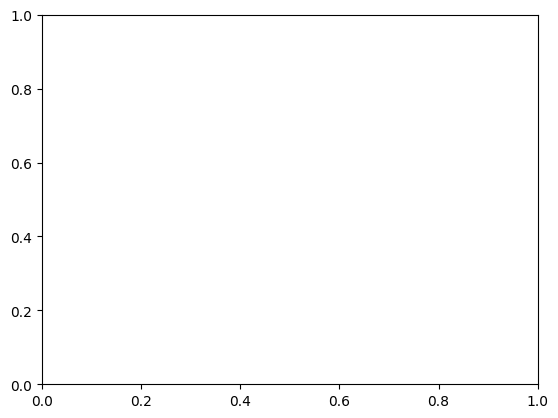

In [ ]:
fig, ax = plt.subplots()
ax.plot(pred_df.index.get_level_values('Year'), pred_df['experienced CDD'], color='k', marker='o', linestyle='None', label='experienced (weighted by fraction in agriculture)')
ax.plot(pred_df.index.get_level_values('Year'), pred_df['CDD'], color='b', marker='o', linestyle='None', label='measured/projected')
ax.set_xlabel('Year')
ax.set_ylabel('Population-weighted CDD')
ax.legend(loc='upper left', bbox_to_anchor=(0., 1.0))
ax.title.set_text('Global population-weighted CDD with projections for SSP3')
plt.savefig('experienced_CDD_with_projections.png', dpi=300, bbox_inches='tight')
plt.show()